# Space Environment Pathways
This Jupyter Notebook will allow users to play around with the scenarios, in order to get to know the laucnh data.

If you would like to use the scen_properties of a pickle file, then this must be located under the first pyssem folder. In the same folder as model.py

In [13]:
import pandas as pd

path = '/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP1.csv' # your path to the scenario csv file
T = pd.read_csv(path)

# Only use if required, you can run the model, it will save a pickle file and then you can use this to get the scenario data. 
# import pickle
# with open('../scenario-properties-baseline.pkl', 'rb') as f:
#     scen_properties = pickle.load(f)

Show all of the columns available, the data types and an example:

In [14]:
# print each column name, the data type and an example
for col in T.columns:
    print(f"Column: {col}")
    print(f"Data Type: {T[col].dtype}")
    print(f"Example: {T[col].iloc[0]}")
    print()

Column: obj_id
Data Type: int64
Example: 1

Column: phase_desc
Data Type: object
Example: debris/derelict

Column: phase
Data Type: int64
Example: 4

Column: par_id
Data Type: float64
Example: nan

Column: operating_agency
Data Type: float64
Example: nan

Column: const_name
Data Type: float64
Example: nan

Column: const_shell_id
Data Type: float64
Example: nan

Column: mass
Data Type: float64
Example: 1.47

Column: area
Data Type: float64
Example: 0.0214

Column: diam_lcola
Data Type: float64
Example: 0.165068

Column: diam_tumbl
Data Type: float64
Example: 0.131711

Column: diam_char
Data Type: float64
Example: 0.146674

Column: obj_type
Data Type: int64
Example: 2

Column: length
Data Type: float64
Example: nan

Column: width
Data Type: float64
Example: nan

Column: depth
Data Type: float64
Example: nan

Column: active
Data Type: float64
Example: 0.0

Column: maneuverable
Data Type: float64
Example: 0.0

Column: stkp_flg
Data Type: float64
Example: 0.0

Column: stkp_box_r
Data Type: 

In [15]:
T.head()

,obj_id,phase_desc,phase,par_id,operating_agency,const_name,const_shell_id,mass,area,diam_lcola,...,inc,raan,aop,ma,eci_x,eci_y,eci_z,eci_vx,eci_vy,eci_vz
0,1,debris/derelict,4,NaN,NaN,NaN,NaN,1.47,0.0214,0.165068,...,34.2488,356.7141,161.3502,206.4756,10067.157110,-569.998349,5.427363,-0.142887,4.737722,3.214775
1,2,debris/derelict,4,NaN,NaN,NaN,NaN,9.80,0.2027,0.508021,...,32.8726,261.0886,323.1294,27.7323,-1095.383555,-7026.596629,4.076188,6.469328,-1.633299,4.293850
2,3,debris/derelict,4,NaN,NaN,NaN,NaN,31.00,0.8834,1.060556,...,32.9067,216.4657,291.5768,51.6791,-6122.128723,-4532.774331,4.322777,2.854645,-5.668931,4.048007
3,4,debris/derelict,4,NaN,NaN,NaN,NaN,31.00,0.8834,1.060556,...,34.2630,209.3806,346.2201,9.0171,-6151.632086,-3470.393250,4.078215,3.049676,-6.077413,4.626719
4,5,debris/derelict,4,NaN,NaN,NaN,NaN,22.70,0.2027,0.508021,...,33.3481,310.9950,195.5980,158.7151,6263.862817,-7195.204310,5.100792,3.938372,3.017737,3.258920


### Use this code - as a template -  to be able to explore the data. 

Now we can check which filters work. 

In [ ]:
def assign_species_to_population(T, species_mapping):
    """
    Applies a list of pandas query strings to assign species classes to the population.
    
    :param T: pandas.DataFrame representing the population
    :param species_mapping: list of assignment strings (e.g., T.loc[...] = ...)
    :return: updated DataFrame with 'species_class' assigned
    """
    # Initialize the column
    T['species_class'] = "Unknown"

    # Apply each mapping rule via exec
    for rule in species_mapping:
        try:
            exec(rule)
        except Exception as e:
            print(f"Error applying rule: {rule}\n\t{e}")

    # Print summary of resulting species_class assignments
    print("\nSpecies class distribution:")
    print(T['species_class'].value_counts())

    # Remove all objects that are still unknown
    try:
        T = T[T['species_class'] != "Unknown"]
        print(f"\n{T['species_class'].value_counts()['Unknown']} objects/rows are being removed.")
    except KeyError:
        print("No unknown species classes found.")

    return T

In [43]:
T_new['const_name'].unique()  # Check unique constant names

array([nan])

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_77283/3562378273.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Species Class')


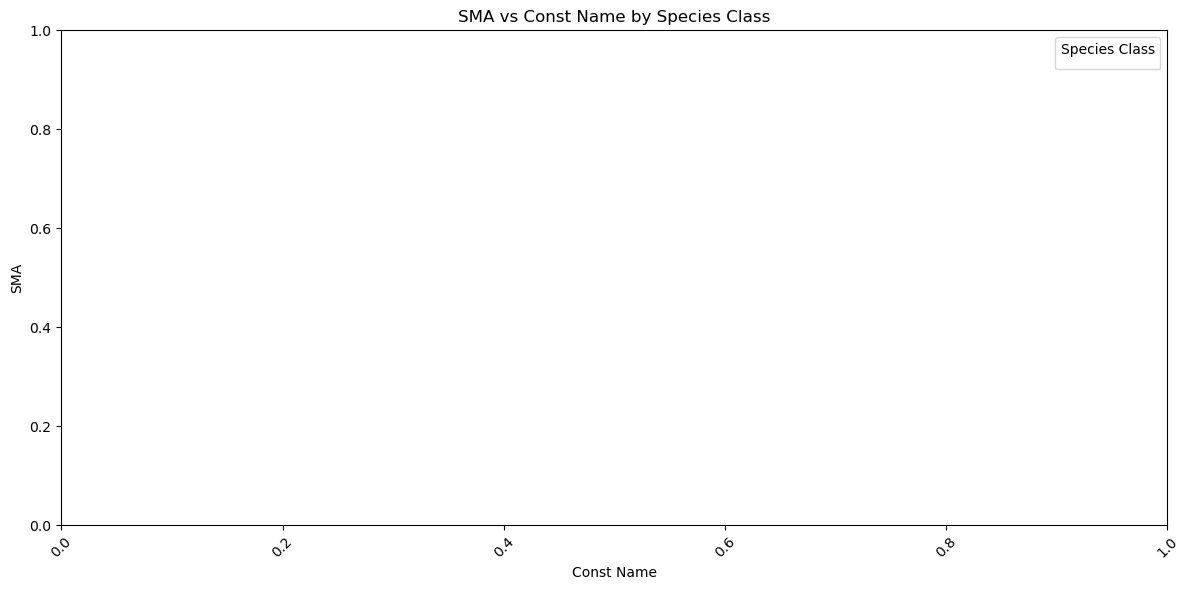

In [40]:
# make a plot of sma for objects where const_name is not nan
def plot_sma(T):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Filter out rows where 'const_name' is NaN
    filtered_T = T[T['const_name'].notna()]

    # Create a scatter plot of 'sma' vs 'const_name'
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=filtered_T, x='const_name', y='sma', hue='species_class', alpha=0.7)
    plt.title('SMA vs Const Name by Species Class')
    plt.xlabel('Const Name')
    plt.ylabel('SMA')
    plt.xticks(rotation=45)
    plt.legend(title='Species Class')
    plt.tight_layout()
    plt.show()

plot_sma(T_new)

In [37]:
# Now we can test different configurations
species_configuration = [
      "T.loc[(T['obj_type'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'Su'",
      "T.loc[(T['obj_type'] == 2) & (T['maneuverable'] == 0), 'species_class'] = 'Sns'",
      "T.loc[(T['phase'] == 2) & (T['mass'].between(220, 235) | T['mass'].between(140, 150) | T['mass'].between(250, 270) | T['mass'].between(295, 315) | T['mass'].between(700, 780) | T['mass'].between(1200, 1300) | T['mass'].between(125, 130)), 'species_class'] = 'S'",
      "T.loc[(T['obj_type'] >= 3), 'species_class'] = 'N'",
      "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
]

# Apply the species configuration
T_new = assign_species_to_population(T, species_configuration)


Species class distribution:
species_class
N      54704
S       6335
Sns     3356
Su      3107
B       2082
Name: count, dtype: int64
No unknown species classes found.


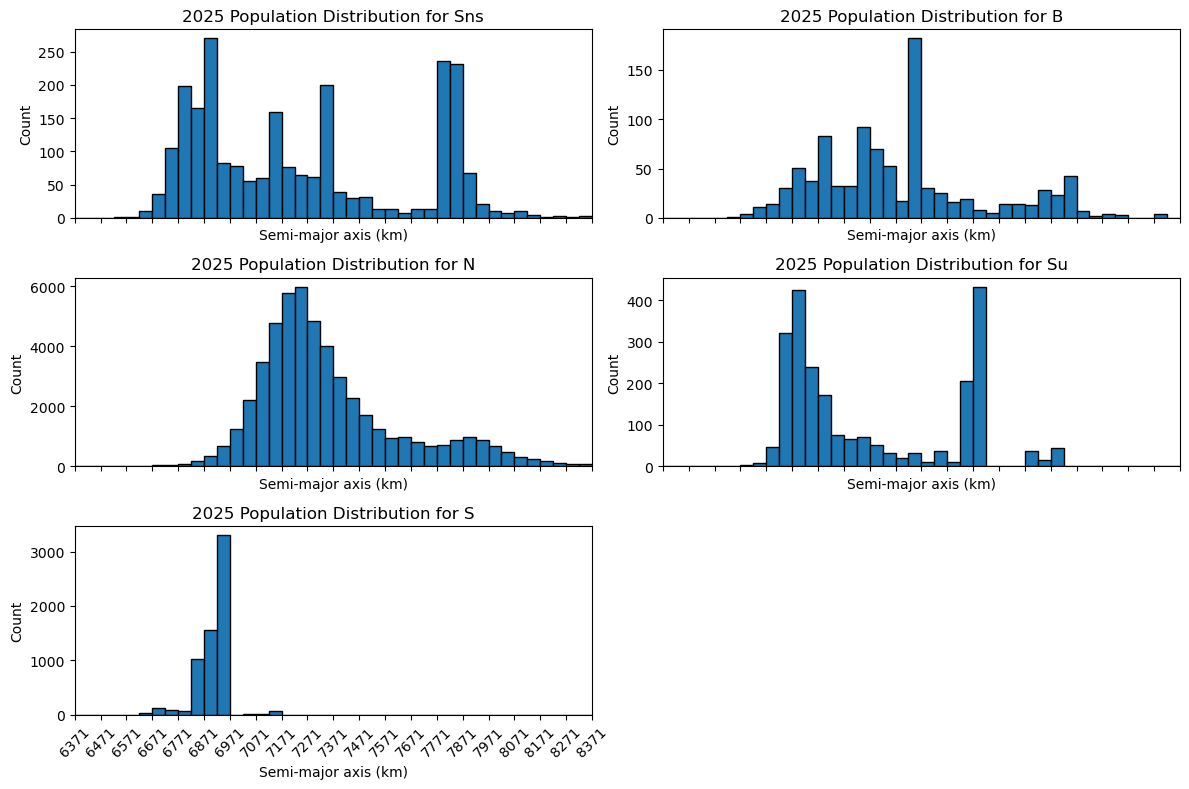

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Column names in your DataFrame ---------------------------------------
SMA_COL      = 'sma'            # semi-major axis (km)
SPECIES_COL  = 'species_class'  # species-class labels
# --------------------------------------------------------------------------

# Bin settings: 0–2000 km altitude ⇒ 6371–8371 km SMA, 50 km bins
BIN_WIDTH = 50
BIN_START = 6371
BIN_END   = 6371 + 2000
bins = np.arange(BIN_START, BIN_END + BIN_WIDTH, BIN_WIDTH)

df = T_new.copy()                                         # your DataFrame
species_classes = df[SPECIES_COL].dropna().unique()   # first 4 classes

# 2 × 2 grid; share x-axis only (y-axis independent)
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for idx, species in enumerate(species_classes):
    data = df.loc[df[SPECIES_COL] == species, SMA_COL].dropna()
    counts, edges = np.histogram(data, bins=bins)

    axes[idx].bar(edges[:-1], counts, width=BIN_WIDTH,
                  align='edge', edgecolor='black')
    axes[idx].set_title(f'2025 Population Distribution for {species}')
    axes[idx].set_xlabel('Semi-major axis (km)')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlim(BIN_START, BIN_END)

    # Show every other x-tick and rotate 45°
    axes[idx].set_xticks(bins[::2])
    axes[idx].tick_params(axis='x', rotation=45)

# Hide any unused sub-plots if fewer than four classes
for ax in axes[len(species_classes):]:
    ax.axis('off')

plt.tight_layout()
plt.show()